In [1]:
import pandas as pd
import numpy as np

import os
import random
import cv2

import numpy as np
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
from os import path
sns.set()
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
import datetime as dt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import calendar
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline
import time
# !pip install tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Dropout

from keras.layers import Conv1D, Flatten,MaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import auc

# Regular Expression for text cleaning
import re
# to track the progress - progress bar
from tqdm.notebook import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load already cleaned text.

In [3]:
df = pd.read_csv("/content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/cleaned_reddit_comments_LSTM.csv").fillna(' ')
df

,label,comment
0,0,nc nh
1,0,know west team play west team east team right
2,0,underdog early today since gronk announcement ...
3,0,meme funny none new york nigga one
4,0,could use one tool
...,...,...
1010821,1,sure iran n. korea technology create pig bird ...
1010822,1,whatever vote green
1010823,1,perhaps atheist conspiracy make christian look...
1010824,1,slavs get country call kosovo


# LSTM-specific Preprocessing
(not run in this notebook. This notebook is for running the LSTM model on the processed dataset.)

In [ ]:
# Lemmatize
import spacy
nlp = spacy.load("en_core_web_sm")

def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_punct])  # Remove punctuation

# (FOR TESTING SAMPLES)
# sample_comments = df["comment"].head(5)
# sample_comments_lemmatized = sample_comments.apply(lemmatize_text)
# for original, lemmatized in zip(sample_comments, sample_comments_lemmatized):
#     print(f"Original: {original}\nLemmatized: {lemmatized}\n")

df['comment'] = df['comment'].apply(lemmatize_text)
df


,label,comment
0,0,nc and nh
1,0,you do know west team play against west team m...
2,0,they be underdog early today but since gronk s...
3,0,this meme be not funny none of the new york ni...
4,0,I could use one of those tool
...,...,...
1010821,1,I be sure that iran and n. korea have the tech...
1010822,1,whatever you do do not vote green
1010823,1,perhaps this be an atheist conspiracy to make ...
1010824,1,the slavs get their own country it be call kosovo


In [ ]:
# Remove stop words (commonly used words that can act as noise)
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return " ".join(filtered_words)

df['comment'] = df['comment'].apply(remove_stopwords)
df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,label,comment
0,0,nc nh
1,0,know west team play west team east team right
2,0,underdog early today since gronk announcement ...
3,0,meme funny none new york nigga one
4,0,could use one tool
...,...,...
1010821,1,sure iran n. korea technology create pig bird ...
1010822,1,whatever vote green
1010823,1,perhaps atheist conspiracy make christian look...
1010824,1,slavs get country call kosovo


In [ ]:
# Save dataset for LSTM
output_path = "/content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/cleaned_reddit_comments_LSTM.csv"
df.to_csv(output_path, index=False)

# Dataset split
Training/Validation/Test : 80/10/10

Constant seed = 42

In [4]:
# total unique words we are going to use.
TOTAL_WORDS = 40000

tokenizer = Tokenizer(num_words=TOTAL_WORDS)
tokenizer.fit_on_texts(list(df['comment']))

strat = df['label']
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 42, stratify= strat)
strat = dummy_df['label']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 42, stratify= strat)

print('Total dataset is ', df.shape)
print('Train shape is ' , train_df.shape)
print('Valid shape is ' , valid_df.shape)
print('Test shape is ' , test_df.shape)


Total dataset is  (1010826, 2)
Train shape is  (808660, 2)
Valid shape is  (101083, 2)
Test shape is  (101083, 2)


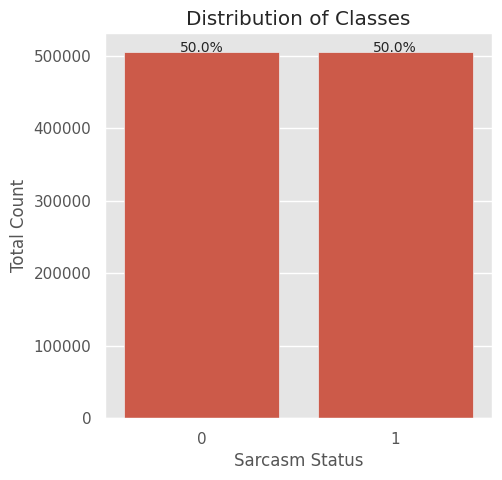

In [5]:
plt.figure(figsize=(5,5))
ax = sns.countplot(x='label',  data= df)
ax.set(title = "Distribution of Classes", xlabel="Sarcasm Status", ylabel = "Total Count")
total = float(len(df ))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.1f}%'.format((height/total)*100),
            ha="center")
plt.show()

In [6]:
# Tokenization
MAX_NUM_WORDS = 40000  # Vocabulary size
MAX_SEQUENCE_LENGTH = 50  # Max length of input sequences

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['comment'])

In [7]:
# Convert text to sequences
X_train = tokenizer.texts_to_sequences(train_df['comment'])
X_valid = tokenizer.texts_to_sequences(valid_df['comment'])
X_test = tokenizer.texts_to_sequences(test_df['comment'])

# Pad sequences to ensure uniform length
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH, padding='pre')
X_valid = pad_sequences(X_valid, maxlen=MAX_SEQUENCE_LENGTH, padding='pre')
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH, padding='pre')

# Convert labels to categorical (0 or 1)
y_train = np.array(train_df['label'])
y_valid = np.array(valid_df['label'])
y_test = np.array(test_df['label'])

In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Input, SpatialDropout1D, GlobalAveragePooling1D, Dropout
from tensorflow.keras.optimizers import Adam

EMBEDDING_DIM = 128  # Word embedding size
LSTM_UNITS = 128
DROPOUT_RATE = 0.3

# Model definition
inputs = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding = Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)(inputs)
x = SpatialDropout1D(0.2)(embedding)
x = LSTM(LSTM_UNITS, return_sequences=True)(x)
x = GlobalAveragePooling1D()(x)  # Extracts key features
x = Dense(64, activation='relu')(x)  # Fully connected layer
x = Dropout(DROPOUT_RATE)(x)  # Prevents overfitting
outputs = Dense(1, activation='sigmoid')(x)  # Binary classification

model = Model(inputs, outputs)



# Model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, 50, 128)             │       5,120,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_2                  │ (None, 50, 128)             │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,259,905 (20.06 MB)

 Trainable params: 5,259,905 (20.06 MB)

 Non-trainable params: 0 (0.00 B)

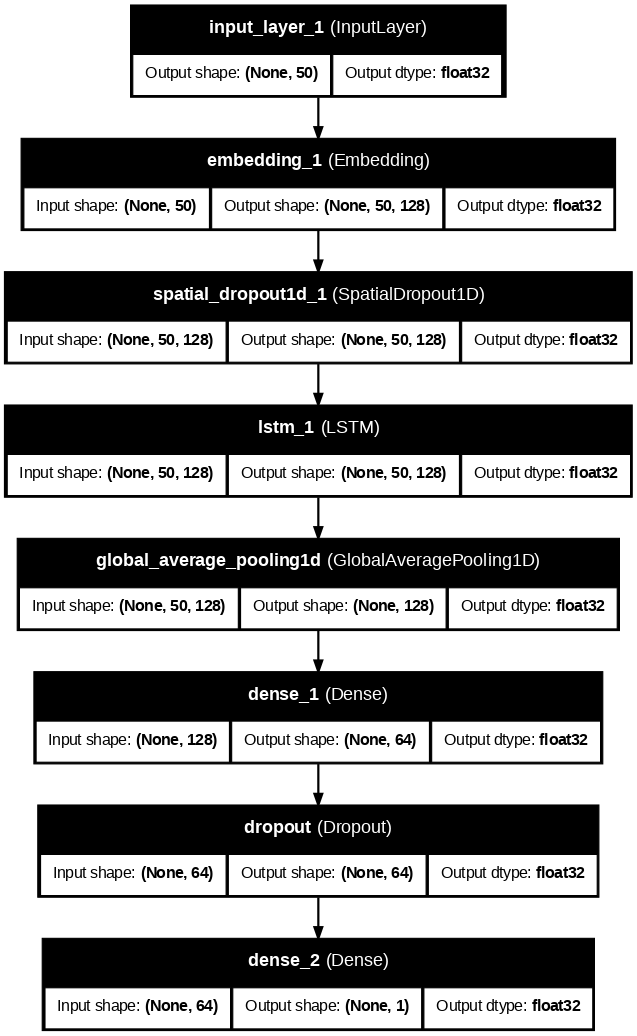

In [22]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=80)

In [24]:
from tensorflow.keras.callbacks import CSVLogger

# Define the CSVLogger callback
csv_logger = CSVLogger("/content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/LSTM_model/March4_LSTM_training_history.csv", append=True)  # Replace with desired path

# Add it to the callbacks list

# Define a checkpoint callback to save the best model

#save_weights_only=True in ModelCheckpoint, the filepath provided must end in .weights.h5 (Keras weights format)
# Set up ModelCheckpoint callback
def checkpoint_callback():
    checkpoint_filepath = "/content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/LSTM_model/March4_LSTM_model.keras"
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                          #  save_weights_only=True,  # Save only the best weights
                           monitor='val_accuracy',
                           mode = 'max',          # 'max' because we are looking for max validation acc
                           save_best_only=True,
                           verbose=1)

    return model_checkpoint_callback

def early_stopping(patience):
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=patience, restore_best_weights=True, verbose=1)
    return es_callback


early_stopping = early_stopping(patience=5)
checkpoint_callback = checkpoint_callback()
callbacks = [checkpoint_callback, early_stopping, csv_logger]

#Create the Adam optimizer with an initial learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5) # Use initial learning rate here
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [25]:
import pickle
hist = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=30,
    batch_size=32,
    verbose=1,
    callbacks=callbacks
)
history_path = "/content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/LSTM_model/March4_LSTM_model.pickle"
with open(history_path, 'wb') as file_pi:
    pickle.dump(hist.history, file_pi)

Epoch 1/30
25270/25271 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5628 - loss: 0.6697
Epoch 1: val_accuracy improved from -inf to 0.66500, saving model to /content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/LSTM_model/March4_LSTM_model.keras
25271/25271 ━━━━━━━━━━━━━━━━━━━━ 280s 11ms/step - accuracy: 0.5628 - loss: 0.6697 - val_accuracy: 0.6650 - val_loss: 0.6108
Epoch 2/30
25266/25271 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6743 - loss: 0.6035
Epoch 2: val_accuracy improved from 0.66500 to 0.68168, saving model to /content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/LSTM_model/March4_LSTM_model.keras
25271/25271 ━━━━━━━━━━━━━━━━━━━━ 332s 11ms/step - accuracy: 0.6743 - loss: 0.6035 - val_accuracy: 0.6817 - val_loss: 0.5947
Epoch 3/30
25270/25271 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6933 - loss: 0.5829
Epoch 3: val_accuracy improved from 0.68168 to 0.68575, saving model to /content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/LSTM_model/March4_LSTM_model

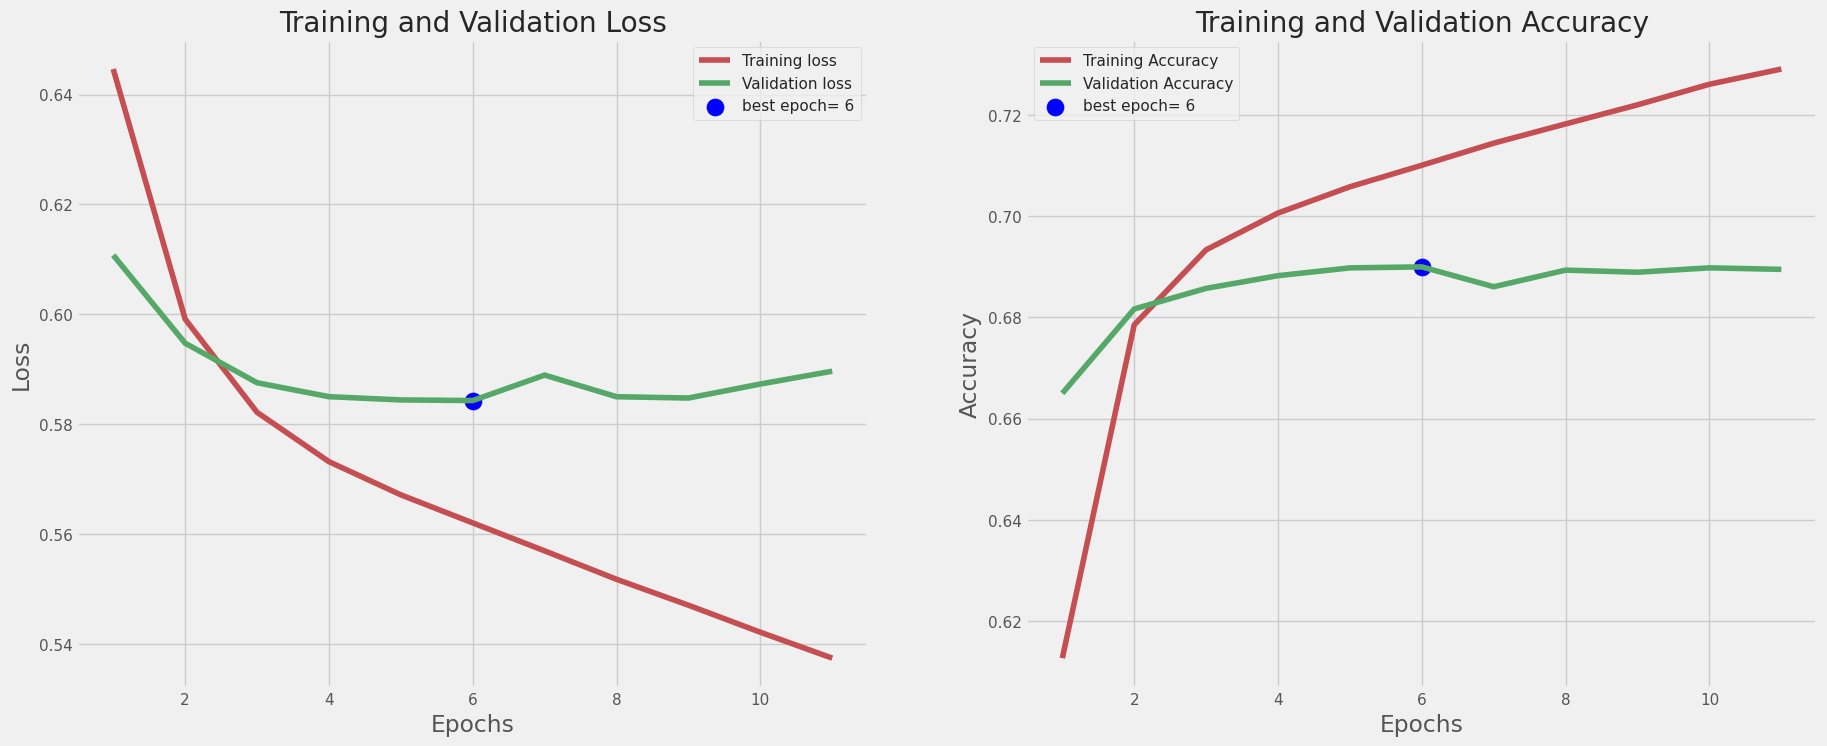

In [26]:
# Function to get true and predicted labels from the dataset
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()
plot_training(hist)


In [27]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

train_score = model.evaluate(X_train, y_train, verbose=1)
valid_score = model.evaluate(X_valid, y_valid, verbose=1)
test_score = model.evaluate(X_test, y_test, verbose=1)


print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

25271/25271 ━━━━━━━━━━━━━━━━━━━━ 117s 5ms/step - accuracy: 0.7201 - loss: 0.5506
3159/3159 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.6903 - loss: 0.5850
3159/3159 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.6859 - loss: 0.5859
Train Loss:  0.5509746670722961
Train Accuracy:  0.7194371223449707
--------------------
Validation Loss:  0.5842902660369873
Validation Accuracy:  0.6899973154067993
--------------------
Test Loss:  0.5844210982322693
Test Accuracy:  0.6877714395523071


In [29]:
embedding_model = Model(inputs=model.input, outputs=model.get_layer('lstm_2').output)
X_test_embeddings = embedding_model.predict(X_test)

print("Shape of extracted embeddings:", X_test_embeddings.shape)  # (num_samples, LSTM_UNITS)


3159/3159 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step
Shape of extracted embeddings: (101083, 50, 128)


In [45]:
class_names = [str(i) for i in range(len(np.unique(y_test)))]
y_pred = model.predict(X_test)

# Convert the predicted probabilities to class labels
y_pred_labels = (y_pred > 0.5).astype(int)
# Get the true class labels from the test data generator
# Check if y_test is one-hot encoded or class labels
if len(y_test.shape) == 2:
    y_true_labels = np.argmax(y_test, axis=1)  # Convert one-hot to class indices
else:
    y_true_labels = y_test  # Already class labels


3159/3159 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step


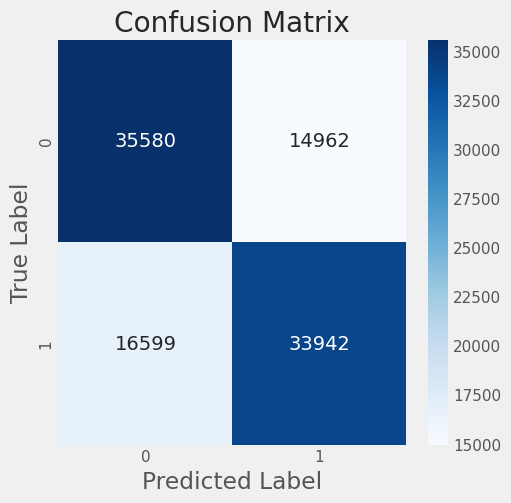

In [46]:


# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true_labels, y_pred_labels)

# Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(confusion_mtx, cmap="Blues", annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [47]:
report = classification_report(y_true_labels, y_pred_labels, target_names=class_names, digits=4)


print("Classification Report: ")
print( report)

Classification Report: 
              precision    recall  f1-score   support

           0     0.6819    0.7040    0.6928     50542
           1     0.6941    0.6716    0.6826     50541

    accuracy                         0.6878    101083
   macro avg     0.6880    0.6878    0.6877    101083
weighted avg     0.6880    0.6878    0.6877    101083



3159/3159 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step


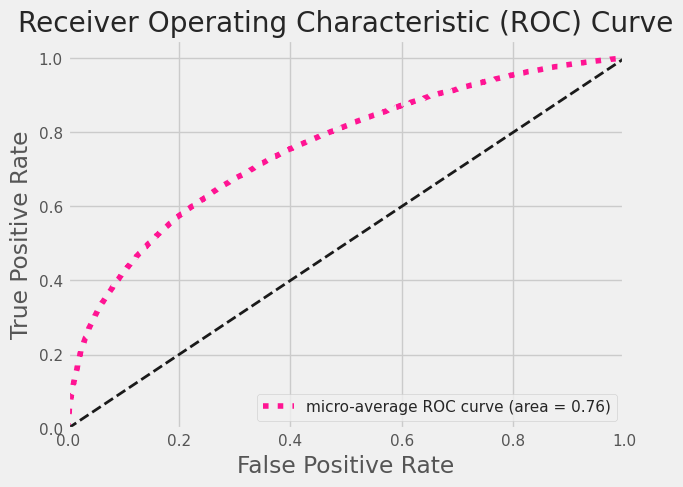

0.7558185380172056

In [49]:
from tensorflow.keras import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


# Binarize the true labels for multi-class ROC calculation
y_true_bin = label_binarize(y_true_labels, classes=np.unique(y_true_labels))
n_classes = y_true_bin.shape[1]  # Number of classes

# Get prediction probabilities instead of predicted labels
y_pred_prob = model.predict(X_test)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot the micro-average ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

# Plot ROC curves for each class (optional)
# for i in range(n_classes):
#     plt.plot(fpr[i], tpr[i], lw=2,
#              label='ROC curve of class {0} (area = {1:0.2f})'
#              ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Get the micro-average AUC value
auc_value = roc_auc["micro"]  # Access the AUC value directly
auc_value